In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/MyDrive/scnn-1st-paper")
%pip install dipy healpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from models import SCNNModel
from sh import l_max, n_coeffs, sh
from sim import compartment_model_simulation

sns.set_theme()

if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
else:
    raise Exception("GPU not available")

batch_size = int(1e3)
n_batches = int(1e5)

Tesla T4


In [3]:
# Acquisition protocol

bvals = torch.tensor(np.loadtxt("data/train-subject/dwi.bval") / 1e3)
bvecs = torch.tensor(np.loadtxt("data/train-subject/dwi.bvec").T)

idx = bvals > 0
bvals = bvals[idx]
bvecs = bvecs[idx]

bs = torch.unique(bvals)
n_shells = len(bs)
shell_idx_list = [torch.where(bvals == b)[0] for b in bs]
bvecs_list = [bvecs[bvals == b] for b in bs]

bvecs_isft_list = []
bvecs_sft_list = []
for bvecs in bvecs_list:
    thetas = torch.arccos(bvecs[:, 2])
    phis = torch.arctan2(bvecs[:, 1], bvecs[:, 0]) + math.pi
    bvecs_isft = torch.zeros((len(bvecs), n_coeffs), dtype=float)
    for l in range(0, l_max + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = sh(l, m, thetas, phis)
    bvecs_isft_list.append(bvecs_isft)
    bvecs_sft = torch.zeros((n_coeffs, len(bvecs)), dtype=float)
    bvecs_sft[0:45] = (
        torch.linalg.pinv(bvecs_isft[:, 0:45].T @ bvecs_isft[:, 0:45])
        @ bvecs_isft[:, 0:45].T
    )
    bvecs_sft_list.append(bvecs_sft.float())

In [4]:
# Validation dataset

SNR = 30

n_val = int(1e5)
n_iter = int(1e3)

torch.random.manual_seed(123)
val_ds = torch.rand(n_val) * 3
val_fs = torch.rand(n_val)
val_odfs_sh = torch.tensor(np.loadtxt("data/val-subject/odfs_sh.txt"))
Rs = torch.tensor(
    np.concatenate(
        (
            np.eye(45)[np.newaxis],
            np.load("Rs_4913.npy").reshape(-1, 45, 45),
        ),
        axis=0,
    )
)
np.random.seed(123)
val_odfs_sh = (
    Rs[np.random.choice(len(Rs), n_val)]
    @ val_odfs_sh[np.random.choice(len(val_odfs_sh), n_val)].unsqueeze(-1)
).squeeze(-1)
val_odfs_sh = torch.hstack((val_odfs_sh, torch.zeros(n_val, n_coeffs - 45)))

val_targets = torch.vstack((val_ds / 3, val_fs)).T
val_signals = torch.zeros(n_val, 120)

for i in range(0, n_val, n_iter):

    idx = torch.arange(i, i + n_iter)

    batch_ads = torch.vstack((val_ds[idx], val_ds[idx])).T
    batch_rds = torch.vstack(
        (
            torch.zeros(len(idx)),
            (1 - val_fs[idx]) * val_ds[idx],
        )
    ).T
    batch_fs = torch.vstack((val_fs[idx], 1 - val_fs[idx])).T
    batch_odfs_sh = val_odfs_sh[idx]

    for j, b in enumerate(bs):
        shell_signals = compartment_model_simulation(
            b.item(),
            bvecs_isft_list[j],
            batch_ads,
            batch_rds,
            batch_fs,
            batch_odfs_sh,
            device,
        ).cpu()
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        val_signals[
            idx,
            shell_idx_list[j].min().item() : shell_idx_list[j].max().item() + 1,
        ] = shell_signals.squeeze(-1).float()

val_signals_sh = torch.zeros(val_signals.size(0), n_shells, n_coeffs)
for i, idx in enumerate(shell_idx_list):
    val_signals_sh[:, i] = (
        bvecs_sft_list[i] @ val_signals[:, idx].unsqueeze(-1)
    ).squeeze(-1)

48930 trainable parameters
validation loss = 0.0032138475216925144
training took 3.49 h


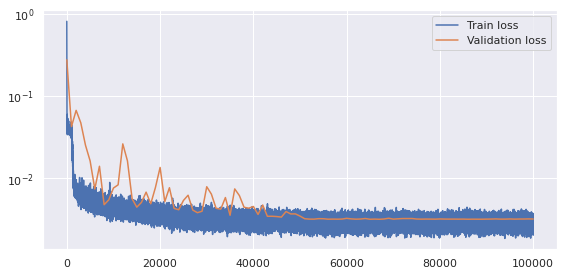

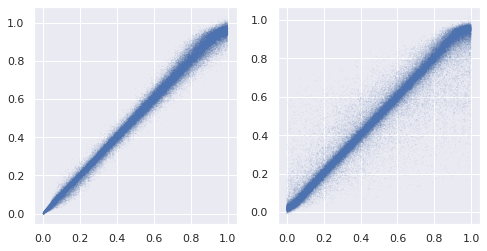

In [5]:
# Training without rotations

torch.random.manual_seed(123)
model = SCNNModel(2, 2, l_max).to(device)
print(f"{sum(p.numel() for p in model.parameters())} trainable parameters")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_odfs_sh = torch.tensor(np.loadtxt("data/train-subject/odfs_sh.txt"))

train_losses = []
val_losses = []

start_time = time.time()

for batch in range(n_batches):

    if batch == int(0.5 * n_batches) or batch == int(0.75 * n_batches):
        scheduler.step()

    torch.random.manual_seed(batch)
    random_ds = torch.rand(batch_size) * 3
    random_fs = torch.rand(batch_size)

    batch_targets = torch.vstack((random_ds / 3, random_fs)).T

    np.random.seed(batch)
    batch_odfs_sh = train_odfs_sh[np.random.choice(len(train_odfs_sh), batch_size)]
    batch_odfs_sh = torch.hstack(
        (batch_odfs_sh, torch.zeros(batch_size, n_coeffs - 45))
    )

    batch_ads = torch.vstack((random_ds, random_ds)).T
    batch_rds = torch.vstack(
        (
            torch.zeros(batch_size),
            (1 - random_fs) * random_ds,
        )
    ).T
    batch_fs = torch.vstack((random_fs, 1 - random_fs)).T

    signals = torch.zeros(batch_size, 120)
    for j, b in enumerate(bs):
        shell_signals = (
            compartment_model_simulation(
                b,
                bvecs_isft_list[j],
                batch_ads,
                batch_rds,
                batch_fs,
                batch_odfs_sh,
                device,
            )
            .cpu()
            .squeeze(-1)
        )
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        signals[:, shell_idx_list[j]] = shell_signals.squeeze(-1).float()

    signals_sh = torch.zeros(batch_size, n_shells, n_coeffs)
    for i, idx in enumerate(shell_idx_list):
        signals_sh[:, i] = (bvecs_sft_list[i] @ signals[:, idx].unsqueeze(-1)).squeeze(
            -1
        )

    y = model(signals_sh.to(device))
    loss = loss_fn(y, batch_targets.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())

    if batch % 1e3 == 0 or batch == n_batches - 1:
        model.eval()
        with torch.no_grad():
            val_preds = torch.zeros(val_targets.size()).to(device)
            for i in range(0, n_val, n_iter):
                idx = torch.arange(i, i + n_iter)
                val_preds[idx] = model(val_signals_sh[idx].to(device))
            val_losses.append(loss_fn(val_preds, val_targets.to(device)).item())
        model.train()

    sys.stdout.write(f"\rbatch = {batch + 1}, train loss = {train_losses[-1]}")
    sys.stdout.flush()

sys.stdout.write(f"\rvalidation loss = {val_losses[-1]}\n")
sys.stdout.flush()

sys.stdout.write(
    f"training took {np.round((time.time() - start_time) / 60 ** 2, 2)} h\n"
)
sys.stdout.flush()

fig = plt.figure(figsize=(8, 4))
plt.plot(np.linspace(1, n_batches, n_batches), train_losses)
plt.plot(np.linspace(1, n_batches, len(val_losses)), val_losses)
plt.yscale("log")
plt.legend(["Train loss", "Validation loss"])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    sc = ax[i].scatter(val_targets[:, i], val_preds[:, i].cpu(), s=1, alpha=0.1)
    sc.set_edgecolor("none")
plt.show()

torch.save(model.state_dict(), "scnn_weights_nonrot.pt")

48930 trainable parameters
validation loss = 0.0032183914445340633
training took 3.5 h


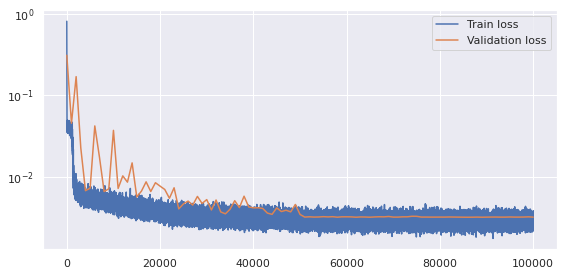

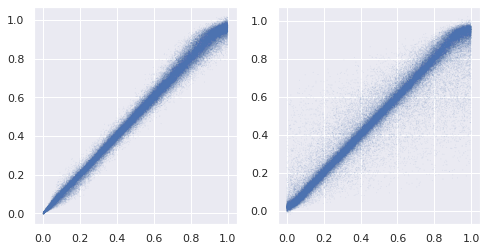

In [6]:
# Training with rotations

torch.random.manual_seed(123)
model = SCNNModel(2, 2, l_max).to(device)
print(f"{sum(p.numel() for p in model.parameters())} trainable parameters")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_odfs_sh = torch.tensor(np.loadtxt("data/train-subject/odfs_sh.txt"))

train_losses = []
val_losses = []

start_time = time.time()

for batch in range(n_batches):

    if batch == int(0.5 * n_batches) or batch == int(0.75 * n_batches):
        scheduler.step()

    torch.random.manual_seed(batch)
    random_ds = torch.rand(batch_size) * 3
    random_fs = torch.rand(batch_size)

    batch_targets = torch.vstack((random_ds / 3, random_fs)).T

    np.random.seed(batch)
    batch_odfs_sh = (
        Rs[np.random.choice(len(Rs), batch_size)]
        @ train_odfs_sh[np.random.choice(len(train_odfs_sh), batch_size)].unsqueeze(-1)
    ).squeeze(-1)
    batch_odfs_sh = torch.hstack(
        (batch_odfs_sh, torch.zeros(batch_size, n_coeffs - 45))
    )
    batch_ads = torch.vstack((random_ds, random_ds)).T
    batch_rds = torch.vstack(
        (
            torch.zeros(batch_size),
            (1 - random_fs) * random_ds,
        )
    ).T
    batch_fs = torch.vstack((random_fs, 1 - random_fs)).T

    signals = torch.zeros(batch_size, 120)
    for j, b in enumerate(bs):
        shell_signals = (
            compartment_model_simulation(
                b,
                bvecs_isft_list[j],
                batch_ads,
                batch_rds,
                batch_fs,
                batch_odfs_sh,
                device,
            )
            .cpu()
            .squeeze(-1)
        )
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        signals[:, shell_idx_list[j]] = shell_signals.squeeze(-1).float()

    signals_sh = torch.zeros(batch_size, n_shells, n_coeffs)
    for i, idx in enumerate(shell_idx_list):
        signals_sh[:, i] = (bvecs_sft_list[i] @ signals[:, idx].unsqueeze(-1)).squeeze(
            -1
        )

    y = model(signals_sh.to(device))
    loss = loss_fn(y, batch_targets.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())

    if batch % 1e3 == 0 or batch == n_batches - 1:
        model.eval()
        with torch.no_grad():
            val_preds = torch.zeros(val_targets.size()).to(device)
            for i in range(0, n_val, n_iter):
                idx = torch.arange(i, i + n_iter)
                val_preds[idx] = model(val_signals_sh[idx].to(device))
            val_losses.append(loss_fn(val_preds, val_targets.to(device)).item())
        model.train()

    sys.stdout.write(f"\rbatch = {batch + 1}, train loss = {train_losses[-1]}")
    sys.stdout.flush()

sys.stdout.write(f"\rvalidation loss = {val_losses[-1]}\n")
sys.stdout.flush()

sys.stdout.write(
    f"training took {np.round((time.time() - start_time) / 60 ** 2, 2)} h\n"
)
sys.stdout.flush()

fig = plt.figure(figsize=(8, 4))
plt.plot(np.linspace(1, n_batches, n_batches), train_losses)
plt.plot(np.linspace(1, n_batches, len(val_losses)), val_losses)
plt.yscale("log")
plt.legend(["Train loss", "Validation loss"])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    sc = ax[i].scatter(val_targets[:, i], val_preds[:, i].cpu(), s=1, alpha=0.1)
    sc.set_edgecolor("none")
plt.show()

torch.save(model.state_dict(), "scnn_weights_rot.pt")